In [130]:
import pandas as pd
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from baseline.immnue_score.scorer import ssGSEA
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label,plot_performance, score2
from compass.tokenizer import CANCER_CODE, CONCEPT
from compass.tokenizer import CONCEPT_palette
from compass.utils import plot_sankey_diagram, get_projector_weights

In [131]:
# load the pretrained model as a feature extractor
finetuner = loadcompass('../checkpoint/latest/finetuner_pft_all.pt', map_location='cpu')
genesetprojector = finetuner.model.latentprojector.genesetprojector
cellpathwayprojector = finetuner.model.latentprojector.cellpathwayprojector

In [132]:
dfcx_pre = pd.read_csv('./data/AMADEUS_Pre_TPM.tsv', index_col = 0, sep = '\t')
df_label_pre = pd.read_csv('./data/AMADEUS_Pre_Clinical.tsv', index_col = 0, sep = '\t')


dfcx_post = pd.read_csv('./data/AMADEUS_Post_TPM.tsv', index_col = 0, sep = '\t')
df_label_post = pd.read_csv('./data/AMADEUS_Post_Clinical.tsv', index_col = 0, sep = '\t')

In [133]:
dfgn_pre, dfgs_pre, dfct_pre = finetuner.extract(dfcx_pre,  batch_size= 32, 
                                                 with_gene_level = True)
_, dfpred_pre = finetuner.predict(dfcx_pre,  batch_size= 32)

dfgn_post, dfgs_post, dfct_post = finetuner.extract(dfcx_post,  batch_size= 32, 
                                                    with_gene_level = True)
_, dfpred_post = finetuner.predict(dfcx_post,  batch_size= 32)

dfct_pre = dfct_pre.join(dfgs_pre['CD8Tcell_sc'].to_frame(name = 'CD8(CD8A,CD8B)'))
dfct_post = dfct_post.join(dfgs_post['CD8Tcell_sc'].to_frame(name = 'CD8(CD8A,CD8B)'))

100%|#####################################################################################| 1/1 [00:00<00:00,  1.35it/s]


In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform  = 'pandas')
dfct_pre = scaler.fit_transform(dfct_pre)
dfct_post = scaler.fit_transform(dfct_post)

In [135]:
c_idx = df_label_pre.index.intersection(df_label_post.index)
print(len(c_idx))

df_label_pre_post = df_label_pre.loc[c_idx]

df_label_pre_post = df_label_pre_post.join(dfpred_pre[1].round(5).to_frame(name = 'P_R'))
df_label_pre_post['pred'] = df_label_pre_post.P_R.apply(lambda x:'R' if x>=0.5 else 'NR')
#df_label_pre_post = df_label_pre_post[df_label_pre_post.response_label == df_label_pre_post.pred]

dfct_post = dfct_post.loc[df_label_pre_post.index]
dfct_pre = dfct_pre.loc[df_label_pre_post.index]

18


In [136]:
c2p = ['CD8(CD8A,CD8B)', 'IFNg_pathway','Cytotoxic_Tcell']

In [137]:
pre = df_label_pre_post['cd8.percent.baseline']
on = df_label_pre_post['cd8.percent.max.ontrt']

pre = pre.to_frame('CD8%').join(dfct_pre[c2p])
pre['point'] = 'pre'

on = on.to_frame('CD8%').join(dfct_post[c2p])
on['point'] = 'post'

data = pd.concat([pre, on])

In [138]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="white", font_scale=1.2)

def plot_cd8_scatter_panel(
    data: pd.DataFrame,
    x_col: str = "CD8%",
    concepts: list = None,
    point_col: str = "point",              # 'pre' / 'post'
    hue_order: tuple = ("pre", "post"),
    method: str = "spearman",
    ncols: int = 3,
    figsize_per_ax=(4.3, 3.6),
    alpha=0.85,
    s = 30,
    add_trend=True,                        # 叠加一条线性趋势线（each hue）
    palette=("tab:blue", "tab:orange"),
):
    """
    data: 形如
        index: patient id
        columns: [CD8%, IFNg_pathway, Cytotoxic_Tcell, ..., point(=pre/post)]
    """
    df = data.copy()
    if concepts is None:
        concepts = [c for c in df.columns if c not in [x_col, point_col]]

    # 画布布局
    k = len(concepts)
    ncols = min(ncols, k) if k > 0 else 1
    nrows = math.ceil(k / ncols)
    fig = plt.figure(figsize=(figsize_per_ax[0]*ncols, figsize_per_ax[1]*nrows))
    sns.set(style="whitegrid")

    # hue 颜色映射
    hue_palette = dict(zip(hue_order, palette))

    # 小工具：格式化 p 值
    def fmt_p(p):
        if p < 1e-4: return "p<1e-4"
        if p < 1e-3: return f"p={p:.1e}"
        if p < 0.01: return f"p={p:.3f}"
        return f"p={p:.2f}"

    for i, concept in enumerate(concepts, start=1):
        ax = fig.add_subplot(nrows, ncols, i)

        # 清洗
        sub = df[[x_col, concept, point_col]].dropna()
        if sub.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_axis_off()
            continue

        # 散点
        sns.scatterplot(
            data=sub, x=x_col, y=concept, hue=point_col, hue_order=hue_order,
            palette=hue_palette, alpha=alpha, s=s, ax=ax, edgecolor="none"
        )

        # 各组 ρ & p（Spearman 或 Pearson）
        texts = []
        for j, g in enumerate(hue_order):
            gsub = sub[sub[point_col] == g]
            if len(gsub) >= 3:
                if method.lower().startswith("spear"):
                    r, p = stats.spearmanr(gsub[x_col], gsub[concept], nan_policy="omit")
                    r_label = r"ρ"
                else:
                    r, p = stats.pearsonr(gsub[x_col], gsub[concept])
                    r_label = "r"
                texts.append((g, r, p))
                # 趋势线
                if add_trend and len(gsub) >= 3:
                    # 简单线性回归拟合（最小二乘）
                    x = gsub[x_col].to_numpy()
                    y = gsub[concept].to_numpy()
                    if np.isfinite(x).sum() >= 2 and np.isfinite(y).sum() >= 2:
                        slope, intercept = np.polyfit(x, y, 1)
                        xx = np.linspace(x.min(), x.max(), 100)
                        yy = slope * xx + intercept
                        ax.plot(xx, yy, color=hue_palette[g], lw=1.5, alpha=0.9)
            else:
                texts.append((g, np.nan, np.nan))

        # 标注文本（左上角）
        y_top = sub[concept].max()
        y_rng = sub[concept].max() - sub[concept].min()
        y_step = (y_rng if y_rng > 0 else 1.0) * 0.08
        x_left = sub[x_col].min()
        x_rng = sub[x_col].max() - sub[x_col].min()
        x_pad = (x_rng if x_rng > 0 else 1.0) * 0.02

        for j, (g, r, p) in enumerate(texts):
            color = hue_palette.get(g, "black")
            lab = f"{g}: ρ={r:.2f}, {fmt_p(p)}" if np.isfinite(r) else f"{g}: n<3"
            ax.text(x_left + x_pad, y_top - j*y_step, lab, color=color,
                    ha="left", va="top",  bbox=dict(facecolor="white", alpha=0.3, edgecolor="none"))

        ax.set_title(concept)
        ax.set_xlabel("CD8 IHC (%)")
        ax.set_ylabel(concept)

        # 图例放外面更清爽
        ax.legend_.remove() if ax.get_legend() else None

    from matplotlib.lines import Line2D
    
    # ---- put legend outside, rename labels ----
    display_names = {"pre": "Baseline", "post": "On-treatment"}  # 显示名映射
    handles = [
        Line2D([0], [0], marker='o', linestyle='', markersize=6,
               color=hue_palette[h], label=display_names.get(h, h))
        for h in hue_order
    ]
    
    # 预留右侧空白给图例
    fig.subplots_adjust(right=0.83)
    
    # 图例放在图外右侧，无标题
    fig.legend(handles=handles,
               loc="center left", bbox_to_anchor=(1.00, 0.5),
               borderaxespad=0., frameon=False)


    fig.tight_layout(w_pad = 3)
    return fig


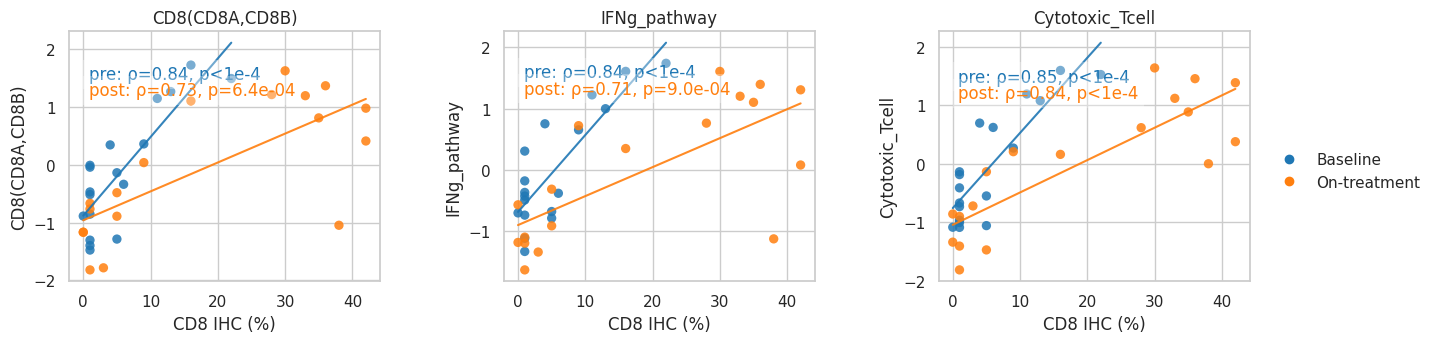

In [139]:
# concepts 不传则自动用除了 CD8% 与 point 的列
fig = plot_cd8_scatter_panel(data, x_col="CD8%", point_col="point",
                             concepts=["CD8(CD8A,CD8B)", "IFNg_pathway", "Cytotoxic_Tcell"],
                             method="Pearson", add_trend=True, #figsize_per_ax = [3.5, 3.5],
                            s = 45,
                            #palette = ['grey', 'yellow'],
                            )
fig.savefig("./results/orthogonai/scatter_panel.svg", dpi=300, bbox_inches="tight")


In [153]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_cd8_delta_panel(
    data: pd.DataFrame,
    x_col: str = "CD8%",            # IHC: CD8 百分比
    concepts: list  = None,   # 要画的概念列；None 则自动取除 x_col/point 的数值列
    point_col: str = "point",       # 'pre' / 'post'
    pre_label: str = "pre",
    post_label: str = "post",
    ncols: int = 3,
    figsize_per_ax=(4.3, 3.6),
    add_trend: bool = True,
    method: str = "spearman",       # 'spearman' or 'pearson'
    color: str = "tab:purple",      # 点与趋势线颜色
):
    """
    data: 行为病人×时间点（pre/post），index 是病人 ID，列包含 x_col、多个概念列、point_col。
    输出：matplotlib Figure
    """
    df = data.copy()
    if concepts is None:
        # 自动收集数值列作为概念
        concepts = [c for c in df.columns if c not in [x_col, point_col] and np.issubdtype(df[c].dtype, np.number)]

    # 预处理：拆出 pre / post 两张表并按 index 对齐
    pre = df[df[point_col] == pre_label]
    post = df[df[point_col] == post_label]

    # 只保留两次都有记录的病人
    common_idx = pre.index.intersection(post.index)
    pre = pre.loc[common_idx]
    post = post.loc[common_idx]

    # 计算 ΔCD8
    d_cd8 = (post[x_col].astype(float) - pre[x_col].astype(float)).rename("ΔCD8%")

    # 画布布局
    k = len(concepts)
    if k == 0:
        raise ValueError("No concept columns to plot.")
    ncols = min(max(ncols, 1), k)
    nrows = math.ceil(k / ncols)

    fig = plt.figure(figsize=(figsize_per_ax[0]*ncols, figsize_per_ax[1]*nrows))
    sns.set(style="whitegrid")

    def fmt_p(p):
        if p < 1e-4: return "p<1e-4"
        if p < 1e-3: return f"p={p:.1e}"
        if p < 0.01: return f"p={p:.3f}"
        return f"p={p:.2f}"

    for i, c in enumerate(concepts, start=1):
        ax = fig.add_subplot(nrows, ncols, i)

        # Δ概念
        if c not in pre.columns or c not in post.columns:
            ax.text(0.5, 0.5, f"{c}\nmissing", ha="center", va="center")
            ax.set_axis_off()
            continue
        d_concept = (post[c].astype(float) - pre[c].astype(float)).rename(f"Δ{c}")

        # 组合数据
        dd = pd.concat([d_cd8, d_concept], axis=1).dropna()
        if dd.empty:
            ax.text(0.5, 0.5, "No paired data", ha="center", va="center")
            ax.set_axis_off()
            continue

        # 散点
        sns.scatterplot(data=dd, x="ΔCD8%", y=f"Δ{c}", s=45, color=color, edgecolor="none", alpha=0.9, ax=ax)

        # 0 轴参考线
        ax.axvline(0, color="gray", lw=1, ls="--", alpha=0.6)
        ax.axhline(0, color="gray", lw=1, ls="--", alpha=0.6)

        # 相关 + 趋势线
        if len(dd) >= 3:
            if method.lower().startswith("spear"):
                r, p = stats.spearmanr(dd["ΔCD8%"], dd[f"Δ{c}"], nan_policy="omit")
            else:
                r, p = stats.pearsonr(dd["ΔCD8%"], dd[f"Δ{c}"])

            # 线性趋势（最小二乘）
            if add_trend and np.isfinite(dd["ΔCD8%"]).sum() >= 2 and np.isfinite(dd[f"Δ{c}"]).sum() >= 2:
                slope, intercept = np.polyfit(dd["ΔCD8%"], dd[f"Δ{c}"], 1)
                xx = np.linspace(dd["ΔCD8%"].min(), dd["ΔCD8%"].max(), 100)
                yy = slope * xx + intercept
                ax.plot(xx, yy, color=color, lw=1.6)

            # 标注
            x_min, x_max = dd["ΔCD8%"].min(), dd["ΔCD8%"].max()
            y_max = dd[f"Δ{c}"].max()
            x_pad = (x_max - x_min or 1.0) * 0.02
            ax.text(x_min + x_pad, y_max, f"ρ={r:.2f}, {fmt_p(p)}",
                    ha="left", va="top", #fontsize=9,
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
        else:
            ax.text(0.5, 0.9, "n<3", transform=ax.transAxes, ha="center", va="top")

        ax.set_title(c)
        ax.set_xlabel("ΔCD8 IHC (%)  (post − baseline)")
        ax.set_ylabel(f"Δ{c}  (post − pre)")

    fig.tight_layout(w_pad = 3)
    return fig


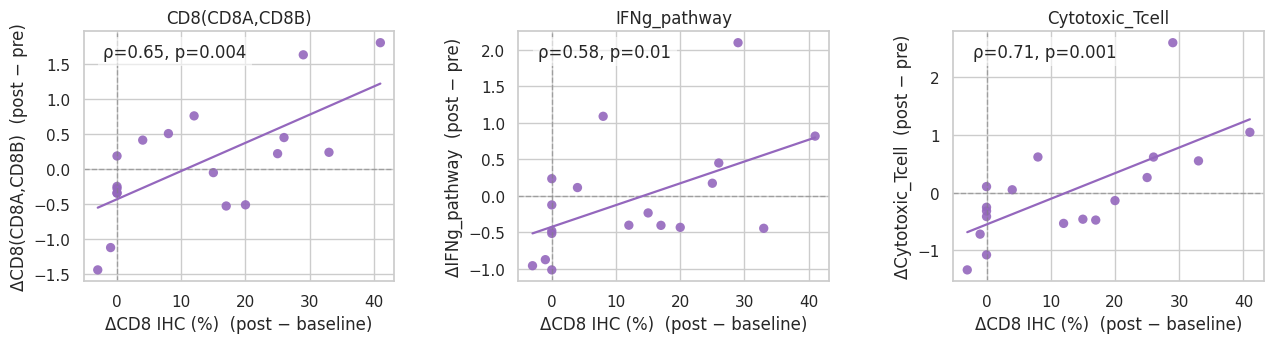

In [154]:
fig2 = plot_cd8_delta_panel(data, x_col="CD8%",
                            concepts=["CD8(CD8A,CD8B)", "IFNg_pathway","Cytotoxic_Tcell"],
                            point_col="point",
                            #figsize_per_ax = [3.5, 3.5],
                            pre_label="pre", post_label="post")

fig2.savefig("./results/orthogonai/delta_scatter_panel.svg", dpi=300, bbox_inches="tight")

In [142]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import ListedColormap

# --- utils ---
def _ensure_dir(path):
    d = os.path.dirname(path) or "."
    os.makedirs(d, exist_ok=True)

def _align_three(df_label, dfct_pre, dfct_post):
    idx = df_label.index.intersection(dfct_pre.index).intersection(dfct_post.index)
    lab  = df_label.loc[idx].copy()
    pre  = dfct_pre.loc[idx].copy()
    post = dfct_post.loc[idx].copy()
    if "cd8_converter_flag" not in lab.columns:
        b = pd.to_numeric(lab["cd8.percent.baseline"], errors="coerce")
        m = pd.to_numeric(lab["cd8.percent.max.ontrt"], errors="coerce")
        lab["cd8_converter_flag"] = np.where((b < 15) & (m >= 15), "Y", "N")
    return lab, pre, post


In [143]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
compass_colors = ['lightblue', 'lightcyan','azure','white','yellow','orange','red']  #
#compass_colors = ['lightblue', 'white', 'orangered'] #orangered
cmap_compass = LinearSegmentedColormap.from_list('compass_default', compass_colors)

In [177]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import colors as mcolors

sns.set(style="white", font_scale=1.1)

def plot_patient_panel_heatmap(
    df_label, dfct_pre, dfct_post,
    concepts=('IFNg_pathway','Cytotoxic_Tcell','CD8A+CD8B'),
    arm_filter=None,               # e.g. 'CD8 LOW'
    sort_rows=True,                # R优先 → 转阳优先 → ΔCD8降序
    outfile="./results/patient_panel_heatmap.png",
    id_col=None,                   # 病人ID列；None 则用 index
    cancer_col="cancer_code",      # 新增：肿瘤类型列名（若不存在则自动跳过）
    fontsize=9,
    left_margin=0.32,
    add_cancer_legend=True,        # 是否在图外添加 Cancer 图例
):
    """
    生成患者级联图：ID / Cancer / Response / CD8 IHC(Pre/Post) / Converter / Concepts(PRE/POST/Δ)
    """
    def _ensure_dir(path):
        d = os.path.dirname(path) or "."
        os.makedirs(d, exist_ok=True)

    def _align_three(df_label, dfct_pre, dfct_post):
        idx = df_label.index.intersection(dfct_pre.index).intersection(dfct_post.index)
        lab  = df_label.loc[idx].copy()
        pre  = dfct_pre.loc[idx].copy()
        post = dfct_post.loc[idx].copy()
        if "cd8_converter_flag" not in lab.columns:
            b = pd.to_numeric(lab["cd8.percent.baseline"], errors="coerce")
            m = pd.to_numeric(lab["cd8.percent.max.ontrt"], errors="coerce")
            lab["cd8_converter_flag"] = np.where((b < 15) & (m >= 15), "Y", "N")
        return lab, pre, post

    _ensure_dir(outfile)
    sns.set_style("white")

    # --- 对齐与可选 arm 过滤 ---
    lab, pre, post = _align_three(df_label, dfct_pre, dfct_post)
    if arm_filter is not None:
        mask = lab["arm"].astype(str).str.contains(str(arm_filter), case=False, na=False)
        lab, pre, post = lab.loc[mask], pre.loc[mask], post.loc[mask]

    # 病人ID标签
    if id_col is not None and id_col in lab.columns:
        patient_labels_all = lab[id_col].astype(str)
    else:
        patient_labels_all = pd.Series(lab.index.astype(str), index=lab.index, name="patient_id")

    # 仅保留存在的概念
    concepts = [c for c in concepts if c in pre.columns and c in post.columns]
    if not concepts:
        raise ValueError("No concepts found in both PRE and POST tables.")

    # 取字段
    cd8_pre   = pd.to_numeric(lab["cd8.percent.baseline"],   errors="coerce")
    cd8_post  = pd.to_numeric(lab["cd8.percent.max.ontrt"],  errors="coerce")
    cd8_delta = cd8_post - cd8_pre
    resp = lab["response_label"].astype(str)     # 'R' / 'NR'
    conv = lab["cd8_converter_flag"].astype(str) # 'Y' / 'N'

    # 排序：R优先→转阳优先→ΔCD8降序
    if sort_rows:
        order = (resp == "R").astype(int) * -1
        order2 = (conv == "Y").astype(int) * -1
        sort_df = pd.DataFrame({"o1": order, "o2": order2, "o3": -cd8_delta.fillna(-1e9)}, index=lab.index)
        row_idx = sort_df.sort_values(["o1","o2","o3"]).index
    else:
        row_idx = lab.index

    patient_labels = patient_labels_all.loc[row_idx].tolist()
    n = len(row_idx)

    # --- Cancer type 列（类别色带）---
    has_cancer = (cancer_col is not None) and (cancer_col in lab.columns)
    if has_cancer:
        cancer_series = lab.loc[row_idx, cancer_col].astype(str)
        cats = pd.Categorical(cancer_series)          # 自动按出现顺序编码
        K = len(cats.categories)
        # 0 预留给 NA（Unknown），1..K 对应真实类别
        codes = pd.Series(cats.codes, index=cancer_series.index).astype(int) + 1
        codes[cats.codes < 0] = 0                     # NA -> 0
        H_cancer = codes.to_numpy().reshape(-1, 1)
        # 调色：第0个为灰，后面用 tab20 或其它
        base_colors = sns.color_palette("tab20", n_colors=max(K, 1))
        colors = ["#d9d9d9"] + [mcolors.to_hex(c) for c in base_colors]
        cmap_cancer = ListedColormap(colors)
        cancer_vmin, cancer_vmax = 0, K
        cancer_labels = ["Unknown"] + list(cats.categories.astype(str))
    else:
        H_cancer = None

    # 其它矩阵
    H_resp  = (resp.loc[row_idx].map({"NR":0, "R":1})).to_numpy().reshape(-1,1)
    H_cd8   = np.c_[cd8_pre.loc[row_idx].to_numpy(), cd8_post.loc[row_idx].to_numpy()]
    H_conv  = (conv.loc[row_idx].map({"N":0, "Y":1})).to_numpy().reshape(-1,1)
    H_pre   = pre.loc[row_idx, concepts].to_numpy()
    H_post  = post.loc[row_idx, concepts].to_numpy()
    H_delta = (post[concepts] - pre[concepts]).loc[row_idx].to_numpy()

    # 色轴范围
    conc_all = np.concatenate([H_pre.ravel(), H_post.ravel(), H_delta.ravel()])
    conc_all = conc_all[~np.isnan(conc_all)]
    vlim = 1 #float(np.clip(np.nanpercentile(np.abs(conc_all), 95) if conc_all.size else 1.5, 1.5, 3.0))
    cd8_vmin, cd8_vmax = 0, 50

    # ---- 布局：根据是否有 cancer 列决定列数 ----
    if has_cancer:
        # [ID, Cancer, Resp, CD8, Conv, Pre, Post, Delta, cbar]
        width_ratios = [1.1, 0.7, 0.6, 1.8, 0.45, 2.2, 2.2, 2.2, 0.2]
        ncols = 9
    else:
        # 原来的 8 列
        width_ratios = [1.1, 0.6, 1.8, 0.45, 2.2, 2.2, 2.2, 0.2]
        ncols = 8

    fig_h = max(4.5, 0.35 * n)
    fig = plt.figure(figsize=(20, fig_h))
    gs = fig.add_gridspec(1, ncols, width_ratios=width_ratios, wspace=0.08)

    if has_cancer:
        ax_ids   = fig.add_subplot(gs[0,0])
        ax_cancer= fig.add_subplot(gs[0,1])
        ax_resp  = fig.add_subplot(gs[0,2])
        ax_cd8   = fig.add_subplot(gs[0,3])
        ax_conv  = fig.add_subplot(gs[0,4])
        ax_pre   = fig.add_subplot(gs[0,5])
        ax_post  = fig.add_subplot(gs[0,6])
        ax_delta = fig.add_subplot(gs[0,7])
        cax      = fig.add_subplot(gs[0,8])
    else:
        ax_ids   = fig.add_subplot(gs[0,0])
        ax_resp  = fig.add_subplot(gs[0,1])
        ax_cd8   = fig.add_subplot(gs[0,2])
        ax_conv  = fig.add_subplot(gs[0,3])
        ax_pre   = fig.add_subplot(gs[0,4])
        ax_post  = fig.add_subplot(gs[0,5])
        ax_delta = fig.add_subplot(gs[0,6])
        cax      = fig.add_subplot(gs[0,7])

    # 统一 y 方向
    for ax in [ax_resp, ax_cd8, ax_conv, ax_pre, ax_post, ax_delta] + ([ax_cancer] if has_cancer else []):
        ax.set_ylim(n, 0)

    # ID 列（文本）
    ax_ids.set_xlim(0, 1)
    ax_ids.set_ylim(n, 0)
    for i, labid in enumerate(patient_labels):
        ax_ids.text(1.0, i + 0.5, labid, ha="right", va="center", color="black")
    ax_ids.axis("off")

    # 调色板
    cmap_resp = ListedColormap(["#c7c7c7", "#2ca02c"])
    cmap_conv = ListedColormap(["#c7c7c7", "#9467bd"])
    cmap_div  = cmap_compass
    
    lw  = 0.01
    lc = 'lightgrey'

    
    # Cancer 列
    if has_cancer:
        annot = np.array(lab.loc[row_idx, cancer_col].astype(str).fillna("").tolist()).reshape(-1,1)
        hm_c = sns.heatmap(H_cancer, ax=ax_cancer, cmap=cmap_cancer, linewidths=lw,  linecolor = lc,
                           vmin=cancer_vmin, vmax=cancer_vmax,
                           cbar=False, yticklabels=False, xticklabels=["Cancer type"],
                           annot=annot, fmt="", annot_kws={"fontsize":fontsize, "color":"black"})
        ax_cancer.set_title("Tumor", pad=10);  plt.setp(ax_cancer.get_xticklabels(), rotation=90)

        # ========= Response with text annotation =========
        resp_labels = resp.loc[row_idx].map({"R": "R", "NR": "NR"}).to_numpy()  # 每行一个标签
        hm_r = sns.heatmap(
            H_resp, ax=ax_resp, cmap=cmap_resp, vmin=0, vmax=1, linewidths=lw,  linecolor = lc,
            cbar=False, yticklabels=False, xticklabels=["Response (R/NR)"]
        )
        ax_resp.set_title("Resp", pad=10); plt.setp(ax_resp.get_xticklabels(), rotation=90)
        
        # 叠加文字：R 放白字，NR 放黑字（按背景色亮度切换）
        for i, lab_txt in enumerate(resp_labels):
            val = float(H_resp[i, 0])
            txt_color = "white" if val >= 0.5 else "black"  # 1=绿色(深) → 白字；0=灰色(浅) → 黑字
            ax_resp.text(0.5, i + 0.5, lab_txt, ha="center", va="center",
                         fontsize=fontsize, color=txt_color, ) #fontweight="bold"
        
        # ========= CD8 IHC with % annotation (你已有，可保留/略调) =========
        sns.heatmap(
            H_cd8, ax=ax_cd8, cmap="Reds", vmin=cd8_vmin, vmax=cd8_vmax, linewidths=lw,  linecolor = lc,
            annot=True, fmt=".0f", annot_kws={"fontsize": fontsize},
            cbar=False, yticklabels=False, xticklabels=["Pre (Baseline)", "Post (On-treatment)"]
        )
        ax_cd8.set_title("CD8 IHC (%)", pad=10); plt.setp(ax_cd8.get_xticklabels(), rotation=90)
        
        # ========= Converter with text annotation =========
        conv_labels = conv.loc[row_idx].map({"Y": "Y", "N": "N"}).to_numpy()
        hm_cnv = sns.heatmap(
            H_conv, ax=ax_conv, cmap=cmap_conv, vmin=0, vmax=1, linewidths=lw,  linecolor = lc,
            cbar=False, yticklabels=False, xticklabels=["CD8 Converter"]
        )
        ax_conv.set_title("Conv", pad=10); plt.setp(ax_conv.get_xticklabels(), rotation=90)
        
        for i, lab_txt in enumerate(conv_labels):
            val = float(H_conv[i, 0])
            txt_color = "white" if val >= 0.5 else "black"  # 1=紫色(较深) → 白字；0=灰色 → 黑字
            ax_conv.text(0.5, i + 0.5, lab_txt, ha="center", va="center",
                         fontsize=fontsize, color=txt_color) #, fontweight="bold"
        

    sns.heatmap(H_pre,  ax=ax_pre,  cmap=cmap_div, vmin=-vlim, vmax=vlim,  linewidths=lw,  linecolor = lc,
                cbar=False, yticklabels=False, xticklabels=concepts)
    ax_pre.set_title("Concepts\n(Pre)", pad=10);  plt.setp(ax_pre.get_xticklabels(), rotation=90)

    sns.heatmap(H_post, ax=ax_post, cmap=cmap_div, vmin=-vlim, vmax=vlim, linewidths=lw,  linecolor = lc,
                cbar=False, yticklabels=False, xticklabels=concepts)
    ax_post.set_title("Concepts\n(Post)", pad=10); plt.setp(ax_post.get_xticklabels(), rotation=90)

    sns.heatmap(H_delta, ax=ax_delta, cmap=cmap_div, vmin=-vlim, vmax=vlim, linewidths=lw,  linecolor = lc,
                cbar=True, cbar_ax=cax, yticklabels=False, xticklabels=concepts)
    ax_delta.set_title("Concepts Δ\n(Post–Pre)", pad=10); plt.setp(ax_delta.get_xticklabels(), rotation=90)
    cax.set_ylabel("z-score / Δ (std units)")

    # Cancer 图例（可选）
    if has_cancer and add_cancer_legend:
        handles = [Patch(facecolor=colors[i], label=lab) for i, lab in enumerate(cancer_labels)]
        # 过滤掉只出现 Unknown 的情况
        handles = [h for h, lab in zip(handles, cancer_labels) if (lab == "Unknown") or (lab in set(cancer_series))]
        fig.legend(handles, title="Cancer type", loc="upper center",
                   bbox_to_anchor=(0.5, 1.06), ncol=4, frameon=False)

    title_suffix = f" [{arm_filter}]" if arm_filter is not None else ""
    fig.suptitle(f"Patient panel heatmap{title_suffix}", y=1.02, fontweight = 'bold')

    plt.subplots_adjust(left=left_margin)
    
    plt.tight_layout()
    
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    return outfile

./results/patient_panel_heatmap_low_1.svg


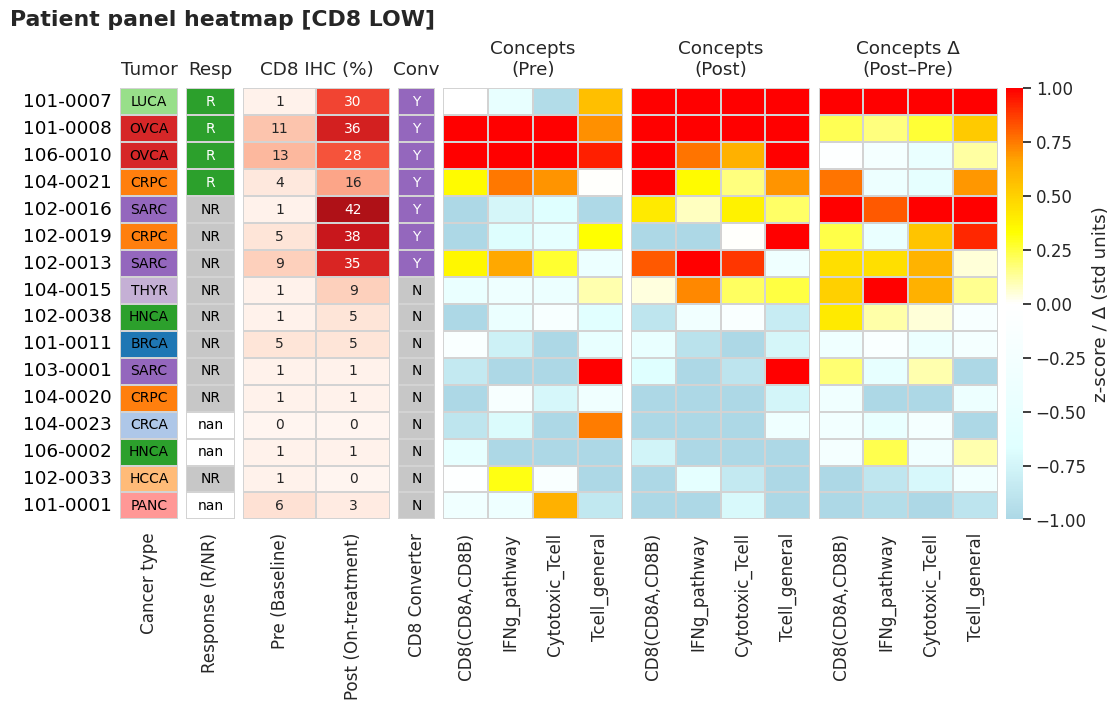

In [178]:
out = plot_patient_panel_heatmap(
    df_label_pre_post, dfct_pre, dfct_post,
    concepts=['CD8(CD8A,CD8B)','IFNg_pathway','Cytotoxic_Tcell','Tcell_general'],
    arm_filter='CD8 LOW', 
    id_col=None,
    fontsize=10,
    left_margin=0.40,
    cancer_col='tumor.type.abbr',
    add_cancer_legend = False,
    outfile='./results/patient_panel_heatmap_low_1.svg')

print(out)

./results/patient_panel_heatmap_low_2.svg


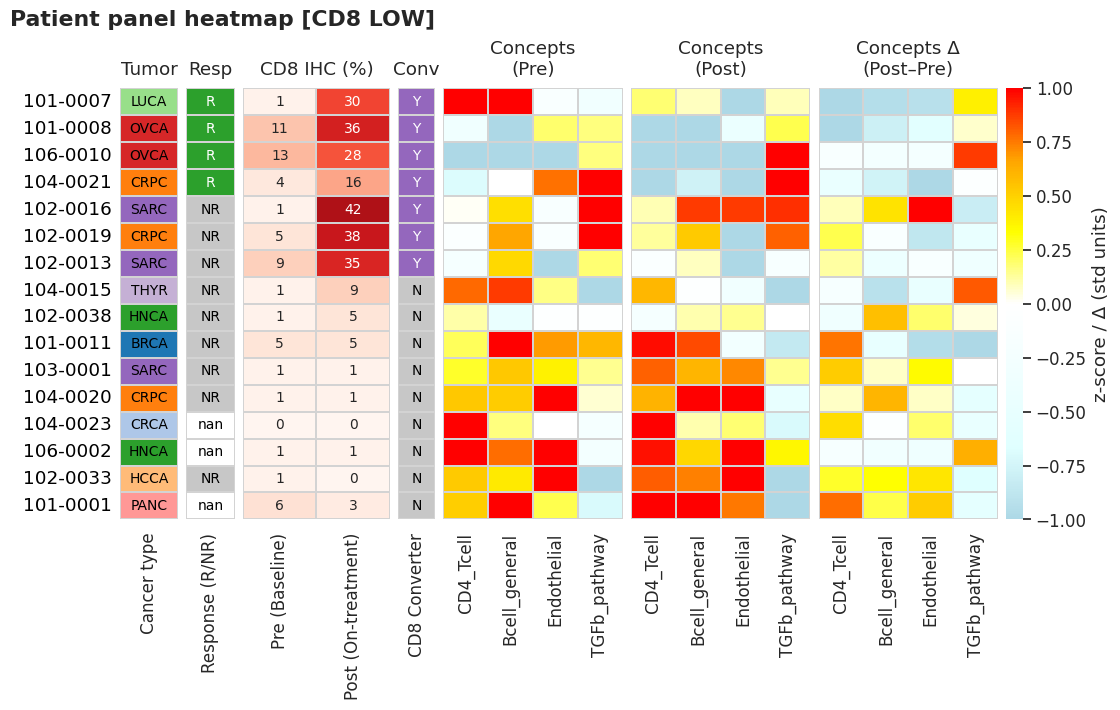

In [179]:
out = plot_patient_panel_heatmap(
    df_label_pre_post, dfct_pre, dfct_post,
    concepts=['CD4_Tcell', 'Bcell_general', 'Endothelial','TGFb_pathway'],
    arm_filter='CD8 LOW', 
    id_col=None,
    fontsize=10,
    left_margin=0.4,
    cancer_col='tumor.type.abbr',
    add_cancer_legend = False,
    outfile='./results/patient_panel_heatmap_low_2.svg')

print(out)